In [1]:
from mealpy import SMA, GA, PSO, ABC, SOS
from knn_new.knn_problem import KnnMetaHeuristicProblem
from knn_new.knn_problem_bounds import (
    get_recommended_config, 
    get_bounds_for_strategy, 
    get_termination_for_strategy,
    COMPLEXITY_CONFIGS
)
from utils.visualize_new import (
    plot_fitness, 
    plot_pareto_analysis, 
    plot_optimization_comparison,
    plot_k_efficiency_analysis
)
import pandas as pd
import numpy as np


In [2]:
# Dataset yükle
diabetes_df = pd.read_csv("datasets/diabetes.csv")
attributes = diabetes_df.drop("Outcome", axis=1)
target = diabetes_df["Outcome"]

print(f"Dataset boyutu: {len(diabetes_df)} samples")
print(f"Feature sayısı: {len(attributes.columns)}")
print(f"Class distribution:\n{target.value_counts()}")


Dataset boyutu: 768 samples
Feature sayısı: 8
Class distribution:
Outcome
0    500
1    268
Name: count, dtype: int64


In [3]:
# Dataset boyutuna göre otomatik konfigürasyon
config = get_recommended_config(len(diabetes_df))
print("Önerilen konfigürasyon:")
for key, value in config.items():
    if key != 'bounds':  # bounds çok uzun
        print(f"  {key}: {value}")


Önerilen konfigürasyon:
  termination: {'max_epoch': 25, 'max_fe': 2500, 'max_early_stop': 10, 'epsilon': 1e-05}
  cv_folds: 3
  complexity_config: efficiency_focused
  complexity_weight: 0.2


In [4]:
# Dengeli optimizasyon (Accuracy + Efficiency)
problem_balanced = KnnMetaHeuristicProblem(
    attributes, target, 
    bounds=config['bounds'],
    use_cv=True,
    cv_folds=config['cv_folds'],
    complexity_weight=config['complexity_weight']
)

# SOS algoritması ile optimizasyon
print("🔄 SOS algoritması çalıştırılıyor...")
model_balanced = SOS.OriginalSOS(epoch=30)
model_balanced.solve(problem_balanced, termination=config['termination'], seed=42)


2025/07/02 01:19:50 PM, INFO, mealpy.bio_based.SOS.OriginalSOS: OriginalSOS(epoch=30, pop_size=100)


🔄 SOS algoritması çalıştırılıyor...


2025/07/02 01:20:20 PM, INFO, mealpy.bio_based.SOS.OriginalSOS: >>>Problem: P, Epoch: 1, Current best: 0.7344399683752049, Global best: 0.7344399683752049, Runtime: 19.06364 seconds
2025/07/02 01:20:40 PM, INFO, mealpy.bio_based.SOS.OriginalSOS: >>>Problem: P, Epoch: 2, Current best: 0.7344399683752049, Global best: 0.7344399683752049, Runtime: 19.99164 seconds
2025/07/02 01:20:59 PM, INFO, mealpy.bio_based.SOS.OriginalSOS: >>>Problem: P, Epoch: 3, Current best: 0.7344399683752049, Global best: 0.7344399683752049, Runtime: 18.16496 seconds
2025/07/02 01:21:17 PM, INFO, mealpy.bio_based.SOS.OriginalSOS: >>>Problem: P, Epoch: 4, Current best: 0.7344399683752049, Global best: 0.7344399683752049, Runtime: 18.50536 seconds
2025/07/02 01:21:37 PM, INFO, mealpy.bio_based.SOS.OriginalSOS: >>>Problem: P, Epoch: 5, Current best: 0.7344399683752049, Global best: 0.7344399683752049, Runtime: 19.82570 seconds
2025/07/02 01:21:55 PM, INFO, mealpy.bio_based.SOS.OriginalSOS: >>>Problem: P, Epoch: 6, C

id: 118, target: Objectives: [0.73443997], Fitness: 0.7344399683752049, solution: [ 6.3790514  20.69668451  1.          0.          0.          0.        ]

Best accuracy: 0.7344399683752049
Best parameters: 
{'n_neighbors': 6, 'leaf_size': 21, 'p': 1, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean'}


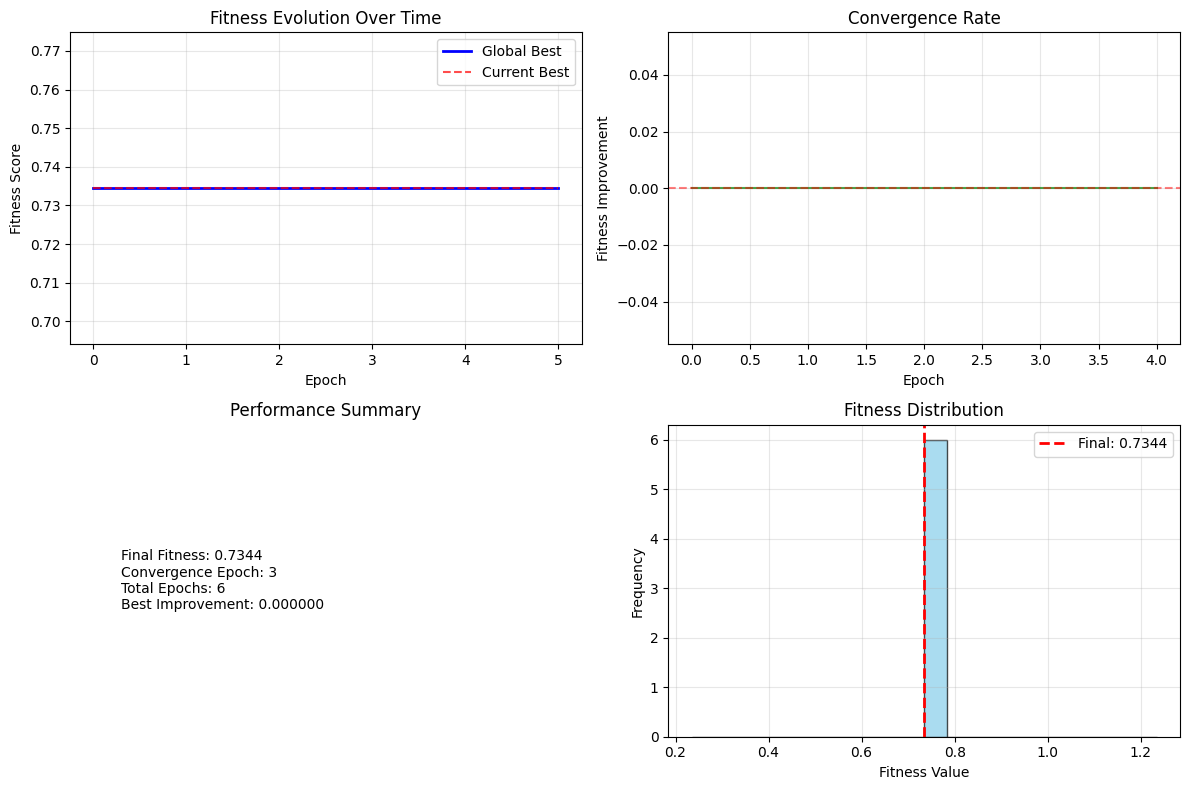

In [5]:
# Gelişmiş görselleştirme
plot_fitness(model_balanced, "Balanced Optimization (CV + Multi-objective)")


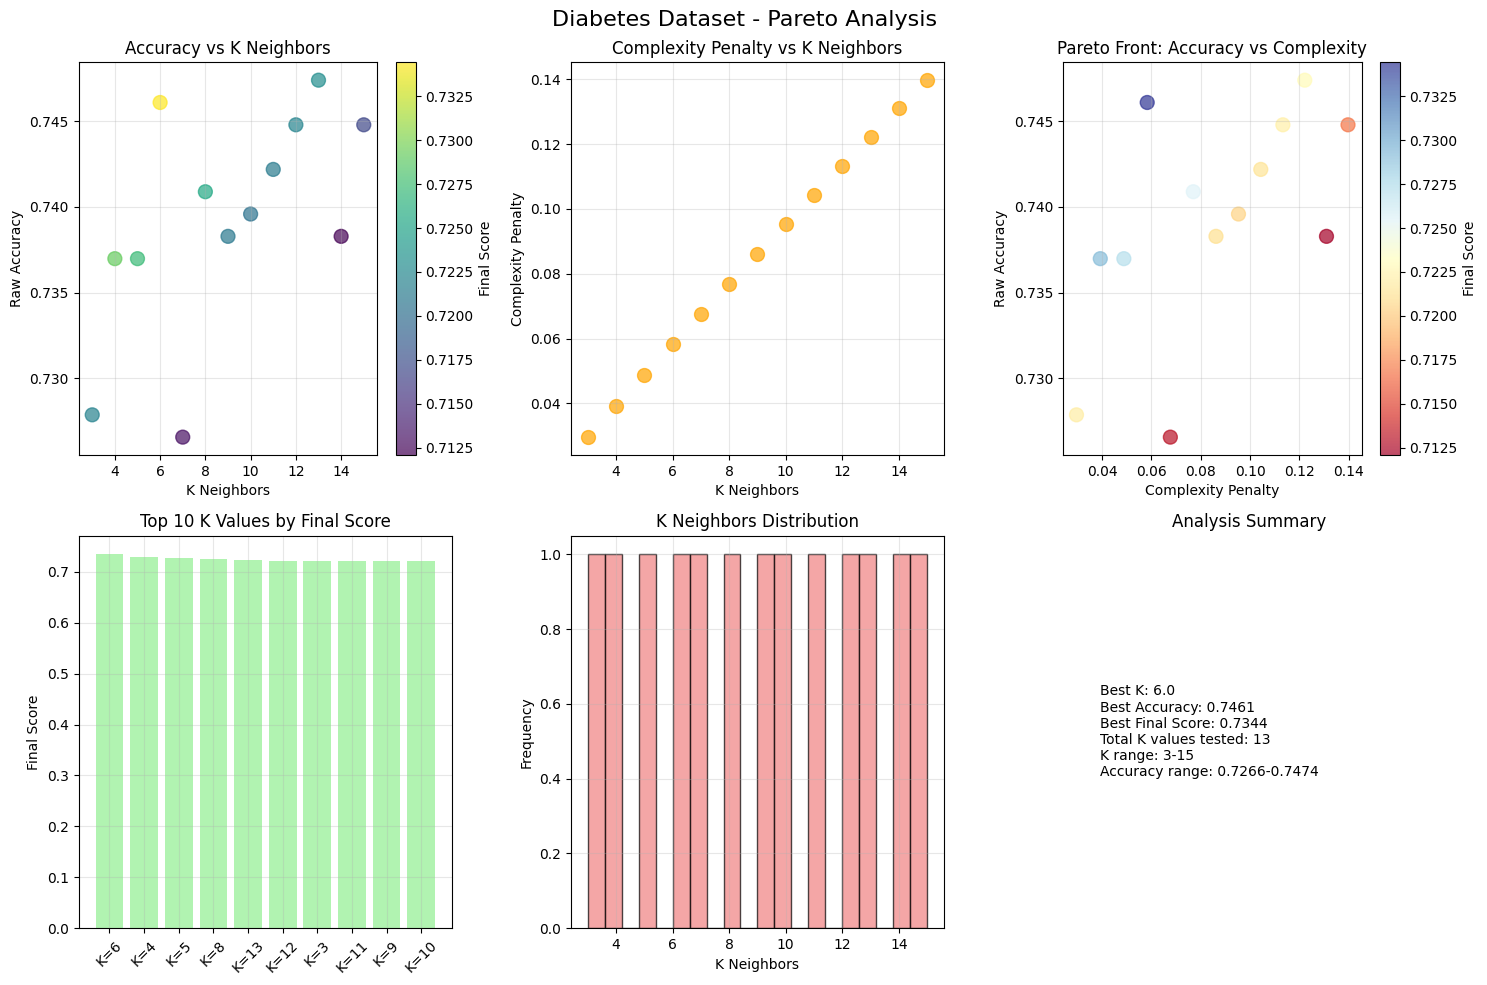

In [6]:
# Pareto front analizi
plot_pareto_analysis(problem_balanced, "Diabetes Dataset - Pareto Analysis")


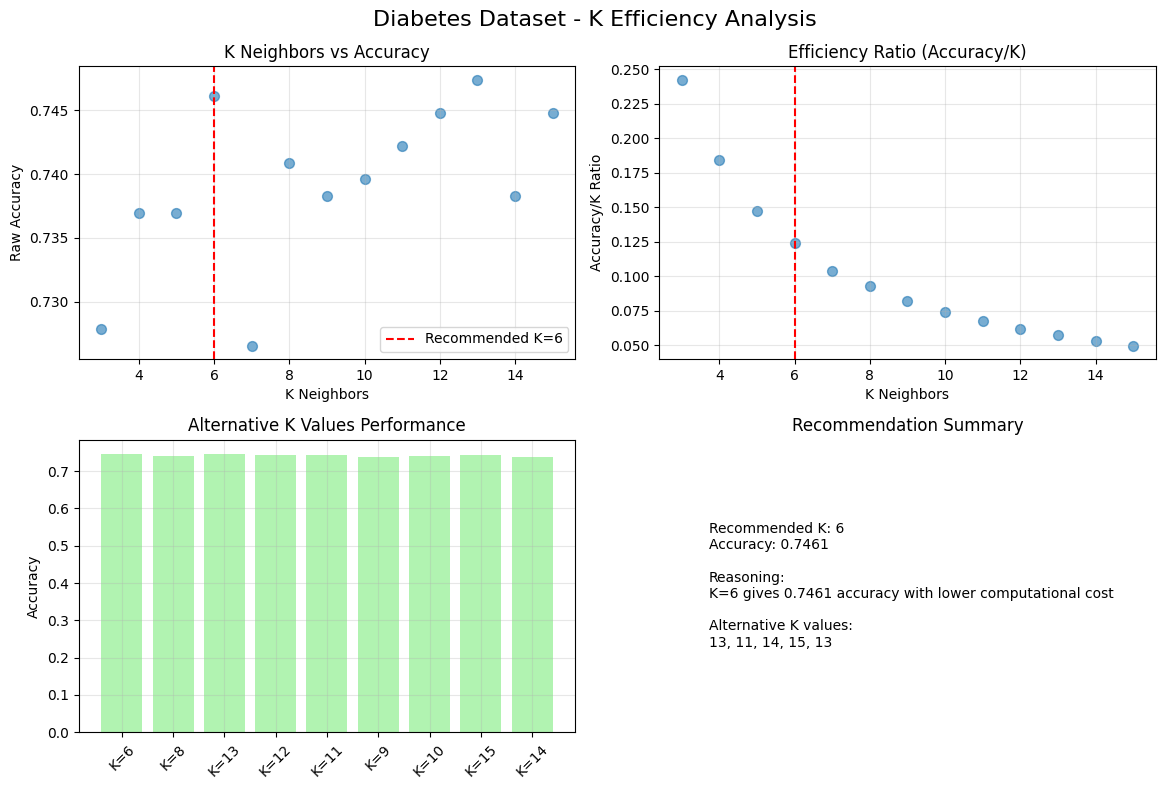

In [7]:
# K değeri efficiency analizi
plot_k_efficiency_analysis(problem_balanced, "Diabetes Dataset - K Efficiency Analysis")


In [8]:
# Optimal K önerisi
recommendation = problem_balanced.recommend_optimal_k()
print("\n🎯 Optimal K Önerisi:")
print(f"Önerilen K: {recommendation['recommended_k']}")
print(f"Accuracy: {recommendation['accuracy']:.4f}")
print(f"Açıklama: {recommendation['reasoning']}")
print(f"Alternatif K değerleri: {recommendation['alternative_ks'][:5]}")



🎯 Optimal K Önerisi:
Önerilen K: 6
Accuracy: 0.7461
Açıklama: K=6 gives 0.7461 accuracy with lower computational cost
Alternatif K değerleri: [13, 11, 14, 15, 13]


In [9]:
# 3 farklı strateji ile karşılaştırma
strategies = {
    'Accuracy Focused': {
        'complexity_weight': COMPLEXITY_CONFIGS['accuracy_focused']['complexity_weight'],
        'description': 'Sadece accuracy maksimize et'
    },
    'Balanced': {
        'complexity_weight': COMPLEXITY_CONFIGS['balanced']['complexity_weight'],
        'description': 'Accuracy ve efficiency dengeli'
    },
    'Efficiency Focused': {
        'complexity_weight': COMPLEXITY_CONFIGS['efficiency_focused']['complexity_weight'],
        'description': 'Düşük K değerlerini tercih et'
    }
}

results = {}
bounds = get_bounds_for_strategy('cv')
termination = get_termination_for_strategy('cv')

for strategy_name, strategy_config in strategies.items():
    print(f"\n🔄 {strategy_name} stratejisi çalıştırılıyor...")
    
    problem = KnnMetaHeuristicProblem(
        attributes, target,
        bounds=bounds,
        use_cv=True,
        cv_folds=5,
        complexity_weight=strategy_config['complexity_weight']
    )
    
    model = PSO.OriginalPSO(epoch=25)  # Hızlı karşılaştırma için
    model.solve(problem, termination=termination, seed=42)
    
    results[strategy_name] = model
    
    # Her strateji için optimal K önerisi
    rec = problem.recommend_optimal_k()
    print(f"  Önerilen K: {rec['recommended_k']}")
    print(f"  Accuracy: {rec['accuracy']:.4f}")


2025/07/02 01:21:58 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: OriginalPSO(epoch=25, pop_size=100, c1=2.05, c2=2.05, w=0.4)



🔄 Accuracy Focused stratejisi çalıştırılıyor...


2025/07/02 01:22:10 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 0.7688952841832516, Global best: 0.7688952841832516, Runtime: 6.00258 seconds
2025/07/02 01:22:16 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 0.7688952841832516, Global best: 0.7688952841832516, Runtime: 5.93110 seconds
2025/07/02 01:22:20 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 0.7688952841832516, Global best: 0.7688952841832516, Runtime: 3.76282 seconds
2025/07/02 01:22:25 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 0.7688952841832516, Global best: 0.7688952841832516, Runtime: 5.06475 seconds
2025/07/02 01:22:30 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 0.7688952841832516, Global best: 0.7688952841832516, Runtime: 4.95189 seconds
2025/07/02 01:22:34 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoc

  Önerilen K: 29
  Accuracy: 0.7630

🔄 Balanced stratejisi çalıştırılıyor...


2025/07/02 01:23:29 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 0.7430706287388612, Global best: 0.7430706287388612, Runtime: 5.55686 seconds
2025/07/02 01:23:35 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 0.7430706287388612, Global best: 0.7430706287388612, Runtime: 5.82102 seconds
2025/07/02 01:23:41 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 0.7430706287388612, Global best: 0.7430706287388612, Runtime: 6.35353 seconds
2025/07/02 01:23:47 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 0.7430706287388612, Global best: 0.7430706287388612, Runtime: 6.03550 seconds
2025/07/02 01:23:52 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 0.7430706287388612, Global best: 0.7430706287388612, Runtime: 4.81135 seconds
2025/07/02 01:23:58 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoc

  Önerilen K: 21
  Accuracy: 0.7617

🔄 Efficiency Focused stratejisi çalıştırılıyor...


2025/07/02 01:25:09 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 0.7343169642363329, Global best: 0.7343169642363329, Runtime: 6.19528 seconds
2025/07/02 01:25:15 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 0.7343169642363329, Global best: 0.7343169642363329, Runtime: 6.38587 seconds
2025/07/02 01:25:20 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 0.7343169642363329, Global best: 0.7343169642363329, Runtime: 4.74519 seconds
2025/07/02 01:25:26 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 0.7343169642363329, Global best: 0.7343169642363329, Runtime: 6.21801 seconds
2025/07/02 01:25:32 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 0.7343169642363329, Global best: 0.7343169642363329, Runtime: 6.08375 seconds
2025/07/02 01:25:39 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoc

  Önerilen K: 29
  Accuracy: 0.7630


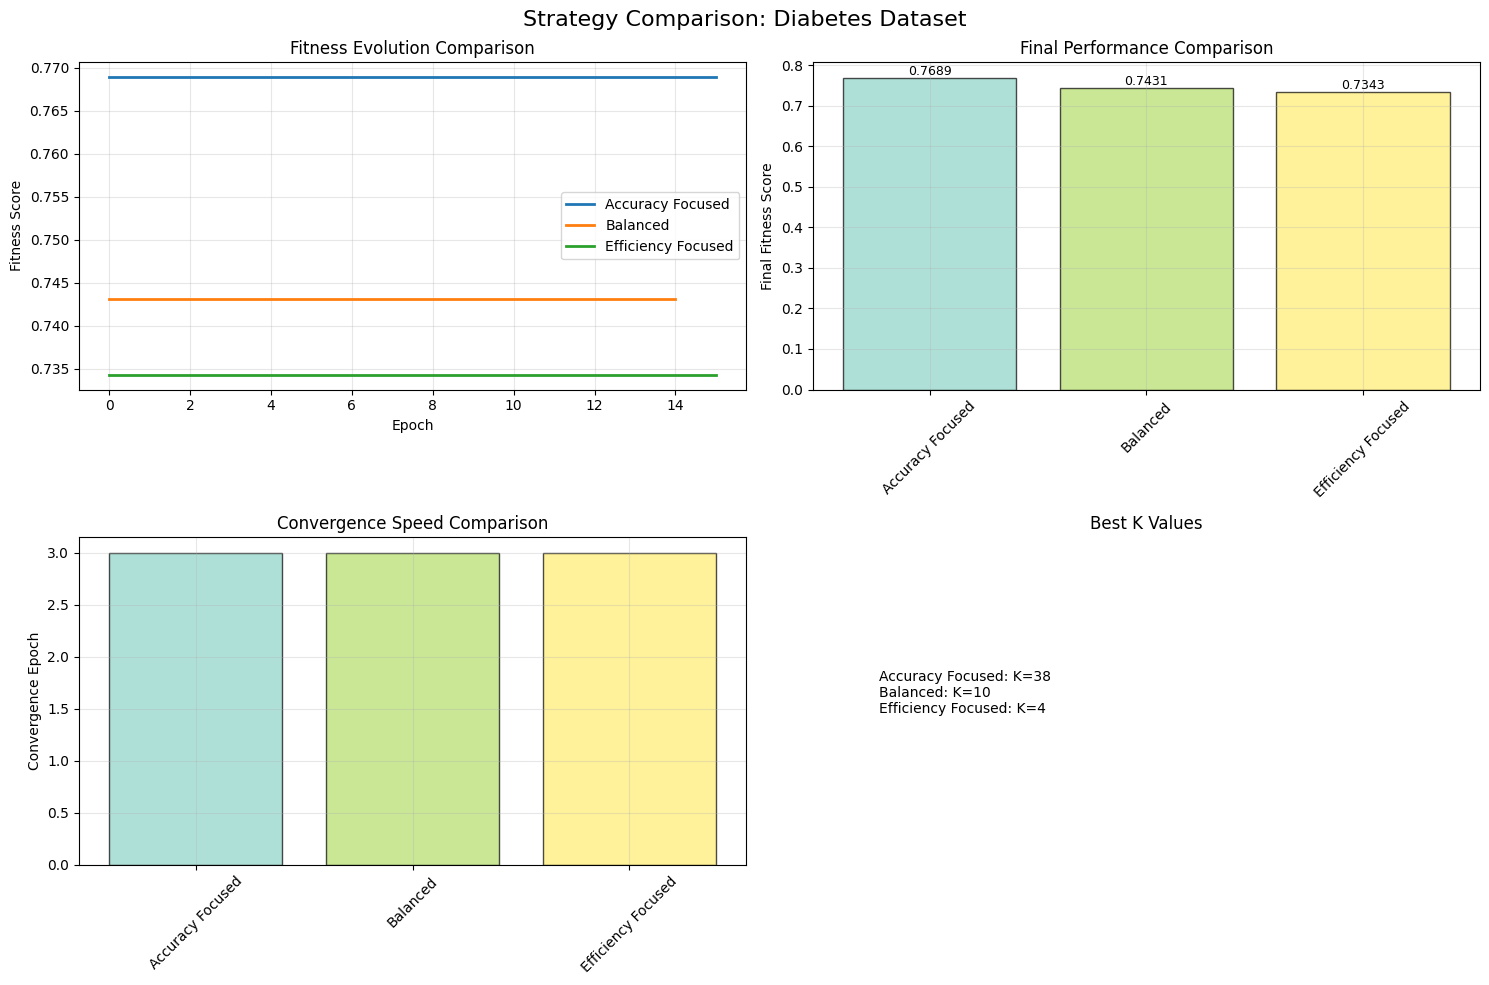

In [10]:
# Stratejileri karşılaştır
plot_optimization_comparison(results, "Strategy Comparison: Diabetes Dataset")


In [11]:
# Farklı meta-sezgisel algoritmaları test et
algorithms = {
    'PSO': PSO.OriginalPSO(epoch=25),
    'GA': GA.BaseGA(epoch=25),
    'ABC': ABC.OriginalABC(epoch=25),
    'SOS': SOS.OriginalSOS(epoch=25),
    'SMA': SMA.OriginalSMA(epoch=25)
}

algorithm_results = {}
bounds = get_bounds_for_strategy('cv')
termination = get_termination_for_strategy('cv')

# Balanced strategy kullan
complexity_weight = COMPLEXITY_CONFIGS['balanced']['complexity_weight']

for alg_name, algorithm in algorithms.items():
    print(f"\n🚀 {alg_name} algoritması çalıştırılıyor...")
    
    problem = KnnMetaHeuristicProblem(
        attributes, target,
        bounds=bounds,
        use_cv=True,
        cv_folds=3,  # Hızlı test için
        complexity_weight=complexity_weight
    )
    
    algorithm.solve(problem, termination=termination, seed=42)
    algorithm_results[alg_name] = algorithm
    
    # Sonuçları yazdır
    best_params = problem.decode_solution(algorithm.g_best.solution)
    print(f"  En iyi fitness: {algorithm.g_best.target.fitness:.4f}")
    print(f"  Önerilen K: {best_params['n_neighbors']}")
    
    # Optimal K önerisi
    rec = problem.recommend_optimal_k()
    print(f"  Akıllı K önerisi: {rec['recommended_k']}")


2025/07/02 01:26:44 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: OriginalPSO(epoch=25, pop_size=100, c1=2.05, c2=2.05, w=0.4)



🚀 PSO algoritması çalıştırılıyor...


2025/07/02 01:26:56 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 0.73781705995295, Global best: 0.73781705995295, Runtime: 5.85312 seconds
2025/07/02 01:27:02 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 0.7402668591876024, Global best: 0.7402668591876024, Runtime: 5.94587 seconds
2025/07/02 01:27:07 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 0.7402668591876024, Global best: 0.7402668591876024, Runtime: 5.34139 seconds
2025/07/02 01:27:13 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 0.7402668591876024, Global best: 0.7402668591876024, Runtime: 5.84777 seconds
2025/07/02 01:27:16 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 0.7402668591876024, Global best: 0.7402668591876024, Runtime: 3.08887 seconds
2025/07/02 01:27:21 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6

  En iyi fitness: 0.7403
  Önerilen K: 6
  Akıllı K önerisi: 24

🚀 GA algoritması çalıştırılıyor...


2025/07/02 01:28:18 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 0.73781705995295, Global best: 0.73781705995295, Runtime: 4.48020 seconds
2025/07/02 01:28:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 0.73781705995295, Global best: 0.73781705995295, Runtime: 4.60419 seconds
2025/07/02 01:28:28 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 0.73781705995295, Global best: 0.73781705995295, Runtime: 5.57237 seconds
2025/07/02 01:28:33 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 0.73781705995295, Global best: 0.73781705995295, Runtime: 5.25831 seconds
2025/07/02 01:28:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 0.73781705995295, Global best: 0.73781705995295, Runtime: 5.37073 seconds
2025/07/02 01:28:43 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, Current 

  En iyi fitness: 0.7378
  Önerilen K: 27
  Akıllı K önerisi: 23

🚀 ABC algoritması çalıştırılıyor...


2025/07/02 01:29:48 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 0.7402668591876024, Global best: 0.7402668591876024, Runtime: 10.17233 seconds
2025/07/02 01:29:57 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 0.7402668591876024, Global best: 0.7402668591876024, Runtime: 8.19482 seconds
2025/07/02 01:30:06 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 0.7402668591876024, Global best: 0.7402668591876024, Runtime: 9.41177 seconds
2025/07/02 01:30:17 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 0.7402668591876024, Global best: 0.7402668591876024, Runtime: 10.71283 seconds
2025/07/02 01:30:28 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 0.7402668591876024, Global best: 0.7402668591876024, Runtime: 11.00525 seconds


KeyboardInterrupt: 

In [ ]:
# Algoritmaları karşılaştır
plot_optimization_comparison(algorithm_results, "Meta-heuristic Algorithm Comparison")


In [ ]:
# Titanic dataset hazırla
titanic_df = pd.read_csv("datasets/titanic.csv")
titanic_df.drop(columns=["Name", "Ticket", "Cabin", "Embarked", "PassengerId"], inplace=True)
titanic_df["Sex"] = titanic_df["Sex"].map({"male": 0, "female": 1})
titanic_df.dropna(inplace=True)

titanic_attributes = titanic_df.drop("Survived", axis=1)
titanic_target = titanic_df["Survived"]

print(f"Titanic dataset boyutu: {len(titanic_df)} samples")
print(f"Feature sayısı: {len(titanic_attributes.columns)}")
print(f"Class distribution:\n{titanic_target.value_counts()}")


In [ ]:
# Titanic için otomatik konfigürasyon
titanic_config = get_recommended_config(len(titanic_df))

titanic_problem = KnnMetaHeuristicProblem(
    titanic_attributes, titanic_target,
    bounds=titanic_config['bounds'],
    use_cv=True,
    cv_folds=titanic_config['cv_folds'],
    complexity_weight=titanic_config['complexity_weight']
)

print("🔄 Titanic dataset için ABC algoritması çalıştırılıyor...")
titanic_model = ABC.OriginalABC(epoch=25)
titanic_model.solve(titanic_problem, termination=titanic_config['termination'], seed=42)


In [ ]:
# Titanic sonuçları
plot_fitness(titanic_model, "Titanic Dataset - Enhanced KNN Optimization")
plot_pareto_analysis(titanic_problem, "Titanic Dataset - Pareto Analysis")

titanic_rec = titanic_problem.recommend_optimal_k()
print("\n🎯 Titanic Dataset Optimal K:")
print(f"Önerilen K: {titanic_rec['recommended_k']}")
print(f"Accuracy: {titanic_rec['accuracy']:.4f}")
print(f"Açıklama: {titanic_rec['reasoning']}")


In [ ]:
# İki dataset'i karşılaştır
dataset_comparison = {
    'Diabetes (SOS)': model_balanced,
    'Titanic (ABC)': titanic_model
}

plot_optimization_comparison(dataset_comparison, "Dataset Comparison: Enhanced KNN Optimization")
